# CS-E-106: Data Modeling
## Fall 2019: HW 09

### Important References and Links

*1. WLS :*

https://www.statsmodels.org/dev/examples/notebooks/generated/wls.html


In [2]:
# ! pip install mlxtend

In [24]:
import numpy as np
import os
import pandas as pd
from scipy import stats
import time
import random
import itertools
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics import gofplots
import pylab
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Imputer, StandardScaler, PolynomialFeatures
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

### Utility Functions

In [25]:
def scale_numeric(fit_df, trans_df, cols):
    df_scaled = trans_df[cols].copy()
    scaler = StandardScaler().fit(fit_df[cols])
    df_scaled = pd.DataFrame(scaler.transform(df_scaled), index=df_scaled.index, columns=cols)
    return(df_scaled)

def scale_encode(fit_df, trans_df, scale_num=True):
    num_cols = list(fit_df.columns[(fit_df.dtypes == 'float64') | (fit_df.dtypes == 'int64')])
    str_cols = list(set(fit_df.columns)^set(num_cols))

    if (len(num_cols)>0) & (len(str_cols)>0):
        if scale_num:
            df_scaled = scale_numeric(fit_df=fit_df, trans_df=trans_df, cols=num_cols)
        else:
            df_scaled = trans_df[num_cols].copy()
        df_dummy = pd.get_dummies(trans_df[str_cols])
        df =  df_scaled.join(df_dummy)
    elif len(str_cols)>0:
        df = pd.get_dummies(trans_df[str_cols])
    elif len(num_cols)>0:
        if scale_num:
            df = scale_numeric(fit_df=fit_df, trans_df=trans_df, cols=num_cols)
        else:
            df = trans_df[num_cols].copy()
    else:
        df = trans_df.copy()
    
    return(df)

**Question 1** Refer to Employee salaries data. A group of high-technology companies agreed to share employee salary information in an effort to establish salary ranges for technical positions in research and development. Data obtained for each employee included current salary (Y), a coded variable indicating highest academic degree obtained (1 = bachelor's degree, 2 = master's degree; 3 = doctoral degree), years of experience since last degree (X3), and the number of persons currently supervised (X4).  (40 pts)

**(a)** Create two indicator variables for highest degree attained: (5pts)

**Solution**

In [26]:
employee_data = pd.read_csv("data/Employee  Salaries.csv")
employee_data["X1"] = pd.get_dummies(employee_data["Degree"]).iloc[:,1]
employee_data["X2"] = pd.get_dummies(employee_data["Degree"]).iloc[:,2]
employee_data.describe()

,Y,Degree,X3,X4,X1,X2
count,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000
mean,60.018462,2.092308,7.958615,3.446154,0.415385,0.338462
std,26.570672,0.764916,7.244190,7.382477,0.496623,0.476869
min,29.000000,1.000000,0.140000,0.000000,0.000000,0.000000
25%,40.900000,2.000000,2.260000,0.000000,0.000000,0.000000
50%,55.900000,2.000000,5.180000,0.000000,0.000000,0.000000
75%,70.600000,3.000000,12.880000,5.000000,1.000000,1.000000
max,163.700000,3.000000,29.540000,42.000000,1.000000,1.000000


**(b)** Regress Y on X1, X2, X3 and X4, using a first-order model and ordinary least squares, obtain the residuals. and plot them against Y ̂. What does the residual plot suggest? (5pts)

**Solution**

In [28]:
lm_employee = ols("Y~X1+X2+X3+X4", data=employee_data).fit()
lm_employee.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     94.76
Date:                Sun, 22 Dec 2019   Prob (F-statistic):           3.16e-25
Time:                        14:12:44   Log-Likelihood:                -240.23
No. Observations:                  65   AIC:                             490.5
Df Residuals:                      60   BIC:                             501.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     31.4714      2.869     10.969      0.000      25.732      37.210
X1            10.8120      3.218      3.360      0.001       4.374      17.250
X2            22.6307      3.485      6.494      0.000      15.660      29.601
X3             1.2581      0.227      5.535      0.000       0.803       1.713
X4             1.8523      0.228      8.137      0.000       1.397       2.308
==============================================================================
Omnibus:                       13.921   Durbin-Watson:                   2.122
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               29.803
Skew:                           0.587   Prob(JB):                     3.38e-07
Kurtosis:                       6.103   Cond. No.                         48.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

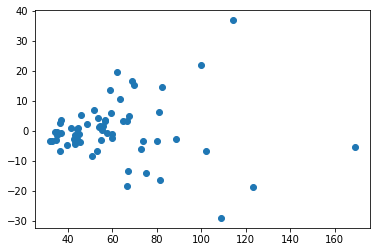

In [29]:
ei = lm_employee.resid
fitted_values = lm_employee.fittedvalues
plt.scatter(fitted_values, ei)


*Interpretation:*

Residual plot shows a megaphone shape which impies non-constant variance. Also, it means that $e_i$ regresses on $\hat{Y}$. 

**(c)** Divide the cases into two groups, placing the 33 cases with the smallest fitted values (Y_i ) ̂ into group 1 and the other 32 cases into group 2. Conduct the Brown-Forsythe test for constancy of the error variance, using α = .01. State the decision rule and conclusion? (5 pts)

**Solution**


*Brown-Forsythe Test*

Null Hypothesis: $H_{0}$: Error variance is constant
Alternate Hypothesis: $H_{1}$: Error variance is not constant

In [36]:
df = employee_data
df["yHat"] = lm_employee.fittedvalues
df["ei"] = lm_employee.resid
df = df.sort_values(by="yHat")
alpha = 0.01

In [37]:
df1 = df[0:33]
df2 = df[33:df.shape[0]]

med1 = np.median(df1["ei"])
med2 = np.median(df2["ei"])

n1 = df1.shape[0]
n2 = df2.shape[0]

d1 = np.abs(df1["ei"]-med1)
d2 = np.abs(df2["ei"]-med2)

mean_d1 = np.mean(d1)
mean_d2 = np.mean(d2)

s2 = (np.var(d1)*(n1-1)+np.var(d2)*(n2-1))/(n1+n2-2)
print(s2)

#calculate s
s = np.sqrt(s2)
print(s)

#testStastic = (mean.d1 - mean.d2) / (s * sqrt((1/n1)+1/n2)
testStastic = (mean_d1-mean_d2)/(s*np.sqrt((1/n1)+(1/n2)))  
print(testStastic)

t = stats.t.ppf(1-alpha, 118)
print(t)

39.2399843218067
6.264182653930734
-4.733856357242809
2.358365099539345


*Decision Rule:*

- If $|testStatistic| \leq t(1-\alpha/2,n-2)$, conclude $H_{0}$: constant error variance

- If $|testStatistic| > t(1-\alpha/2,n-2)$, conclude $H_{1}$: non-constant error variance 


*Result:*

Since $|-4.659428| > 2.390119$ i.e. $|testStatistic| > t(1-\alpha/2,n-2)$, we conclude $H_{1}$. The error variance is not constant and thus varies with X.


**(d)** 

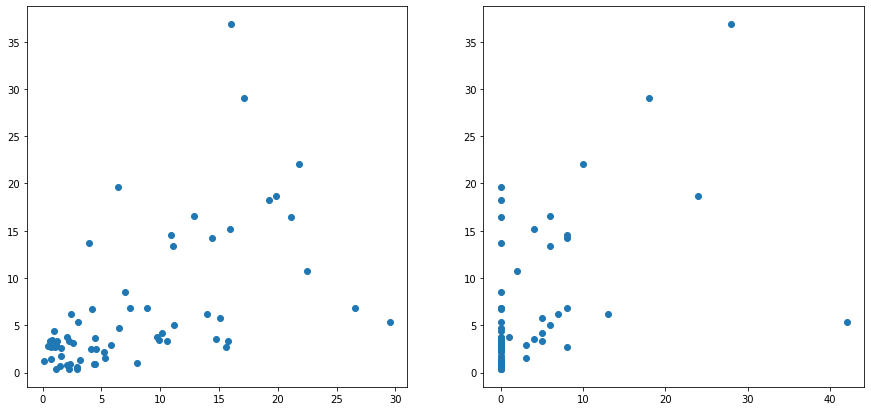

In [41]:
ei_abs = np.abs(ei)

fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].scatter(employee_data["X3"], ei_abs)
ax[1].scatter(employee_data["X4"], ei_abs)

*Interpretation:*

We can see a megaphone shape indicating non-constant variance in the error term.



**(e)** Estimate the. standard deviation function by regressing the absolute residuals against X3 and X4 in first-order form, and then calculate the estimated weight for each case using equation 11.16a on the book. (5pts)


In [63]:
employee_data["ei_abs"] = ei_abs
lm_ei_1e = ols("ei_abs~X3+X4", data=employee_data).fit()
lm_ei_1e.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 ei_abs   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     18.18
Date:                Sun, 22 Dec 2019   Prob (F-statistic):           6.12e-07
Time:                        15:00:54   Log-Likelihood:                -205.88
No. Observations:                  65   AIC:                             417.8
Df Residuals:                      62   BIC:                             424.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4204      1.111      2.179      0.033       0.200       4.641
X3             0.3996      0.131      3.040      0.003       0.137       0.662
X4             0.2695      0.129      2.089      0.041       0.012       0.527
==============================================================================
Omnibus:                       16.385   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.604
Skew:                           0.635   Prob(JB):                     5.61e-10
Kurtosis:                       6.757   Cond. No.                         19.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
si = lm_ei_1e.fittedvalues
wi = 1./(si**2)

0     0.056293
1     0.077706
2     0.001533
3     0.024531
4     0.163068
        ...   
60    0.040548
61    0.031690
62    0.148355
63    0.094115
64    0.003541
Length: 65, dtype: float64

**(f)** Using the estimated weights, obtain the weighted least squares fit of the regression model. Are the weighted least squares estimates of the regression coefficients similar to the ones obtained with ordinary least squares in part (b)? (5 pts)

In [65]:
X = employee_data[["X3", "X4"]]
y = employee_data["Y"]
X = sm.add_constant(X)

lm_1f = sm.WLS(y, X, weights=wi).fit()
lm_1f.summary()

/home/srk-apts/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.397
Model:                            WLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     20.38
Date:                Sun, 22 Dec 2019   Prob (F-statistic):           1.57e-07
Time:                        15:01:02   Log-Likelihood:                -263.43
No. Observations:                  65   AIC:                             532.9
Df Residuals:                      62   BIC:                             539.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         42.0084      1.841     22.812      0.000      38.327      45.689
X3             1.2470      0.450      2.769      0.007       0.347       2.147
X4             2.3880      0.722      3.307      0.002       0.945       3.831
==============================================================================
Omnibus:                        4.030   Durbin-Watson:                   1.671
Prob(Omnibus):                  0.133   Jarque-Bera (JB):                3.434
Skew:                           0.559   Prob(JB):                        0.180
Kurtosis:                       3.135   Cond. No.                         6.84
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

*Interpretation:*

The weighted least squares estimates for the coefficients $\beta_3$ and $\beta_4$ appear very close.

**(g)** Compare the estimated standard deviations of the weighted least squares coefficient estimates in part (f) with those for the ordinary least squares estimates in pan (b). What do you find? (5 pts)

In [66]:
lm_1f.conf_int(alpha=0.05)

,0,1
const,38.327355,45.689444
X3,0.346817,2.147252
X4,0.944527,3.831472


In [67]:
lm_employee.conf_int(alpha=0.05)

,0,1
Intercept,25.732420,37.210441
X1,4.374379,17.249525
X2,15.660465,29.600990
X3,0.803464,1.712784
X4,1.396962,2.307664


*Interpretation:*

$\beta_3$ and $\beta_4$ seem to have overlapping intervals

**(h)** Iterate the steps in parts (e) and (f) one more time. Is there a substantial change in the estimated regression coefficients? If so, what should you do? (10 pts)


In [68]:
employee_data["ei_abs2"] = np.abs(lm_1f.resid)
lm_ei_1h = ols("ei_abs2~X3+X4", data=employee_data).fit()
lm_ei_1h.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ei_abs2   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     3.655
Date:                Sun, 22 Dec 2019   Prob (F-statistic):             0.0316
Time:                        15:03:56   Log-Likelihood:                -218.77
No. Observations:                  65   AIC:                             443.5
Df Residuals:                      62   BIC:                             450.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.6861      1.354      6.414      0.000       5.979      11.393
X3             0.1189      0.160      0.742      0.461      -0.201       0.439
X4             0.2416      0.157      1.536      0.130      -0.073       0.556
==============================================================================
Omnibus:                        5.489   Durbin-Watson:                   2.244
Prob(Omnibus):                  0.064   Jarque-Bera (JB):                4.654
Skew:                           0.625   Prob(JB):                       0.0976
Kurtosis:                       3.396   Cond. No.                         19.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [69]:
si = lm_ei_1h.fittedvalues
wi = 1/(si**2)

lm_1h = sm.WLS(y, X, weights=wi).fit()
lm_1h.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.636
Model:                            WLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     54.16
Date:                Sun, 22 Dec 2019   Prob (F-statistic):           2.48e-14
Time:                        15:05:14   Log-Likelihood:                -255.85
No. Observations:                  65   AIC:                             517.7
Df Residuals:                      62   BIC:                             524.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.8457      2.203     18.993      0.000      37.441      46.250
X3             1.3269      0.309      4.296      0.000       0.709       1.944
X4             2.2168      0.416      5.333      0.000       1.386       3.048
==============================================================================
Omnibus:                        3.542   Durbin-Watson:                   1.771
Prob(Omnibus):                  0.170   Jarque-Bera (JB):                3.460
Skew:                           0.527   Prob(JB):                        0.177
Kurtosis:                       2.590   Cond. No.                         13.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


*Interpretation:*

There doesn't seem to be much difference in the coefficients in the models `lm_1f` (part f model) and `lm_1h` (part h model). However, there seems to be a significant improvement in the $R^2$. 

So we should probably do one more iteration and see if it gives us an improvement, or else stop and use the weights identified part (h).